In [98]:
#Import dependencies
import MS263_project_functions as myfuncs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import stats
import pingouin as pg
import datetime
import pytz
import pandas as pd
import datetime
from scipy.stats import f_oneway
import cartopy.io.img_tiles as cimgt
from scipy.stats import linregress

In [100]:
#Import and organize data

ds04 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0004-D.nc')
ds05 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0005-C.nc')
ds06 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0006-D.nc')
ds07 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0007-C.nc')
ds08 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0008-C.nc')
ds09 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0009-C.nc')
ds10 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0010-C.nc')
ds11 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0011-C.nc')
ds12 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0012-C.nc')
ds13 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0013-C.nc')
ds14 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0014-C.nc')
ds15 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0015-C.nc')
ds16 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0016-C.nc')
ds17 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0017-C.nc')
ds18 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0018-C.nc')
ds19 = xr.open_dataset('data/odas_data/matched_wind_turbulence-0019-C.nc')

dsall = [ds04, ds05, ds06, ds07, ds08, ds09, ds10, ds11, ds12, ds13, ds14,
         ds15, ds16, ds17, ds18, ds19]


df_out_buoy = pd.read_csv("data/wind_data/bouy_46011_wind - Sheet1.csv", header=None)
df_out_buoy.rename(columns={0: 'yr',1: 'mo',2: 'dy',3: 'hr', 4: 'mn', 5: 'degT', 6: 'wndsd'}, inplace=True)

df_in_buoy = pd.read_csv("data/wind_data/Cal_poly_wind - Sheet1.csv", header=None)
df_in_buoy.rename(columns={0: 'yr',1: 'mo',2: 'dy',3: 'hr', 4: 'mn', 5: 'degT', 6: 'wndsd'}, inplace=True)

df_out_buoy['datetime_utc'] = pd.to_datetime({'year': df_out_buoy['yr'],'month': df_out_buoy['mo'],
                            'day': df_out_buoy['dy'],'hour': df_out_buoy['hr'],'minute': df_out_buoy['mn']}, utc=True)

df_in_buoy['datetime_utc'] = pd.to_datetime({'year': df_in_buoy['yr'],'month': df_in_buoy['mo'],
                            'day': df_in_buoy['dy'],'hour': df_in_buoy['hr'],'minute': df_in_buoy['mn']}, utc=True)

# Convert to Los Angeles local time (Pacific Time, handles DST)
df_out_buoy['datetime_local'] = df_out_buoy['datetime_utc'].dt.tz_convert('America/Los_Angeles')
df_in_buoy['datetime_local'] = df_in_buoy['datetime_utc'].dt.tz_convert('America/Los_Angeles')

# Introduction
Although wind forcing's dominant role in driving ecosystem dynamics in upwelling systems has been well documented, the effect of wind forcing on smaller scale dynamics like turbulence and mixing within upwelling embayments remains unclear. This data project will investigate the interaction between regional and upwelling winds, and their relative impact on the rate of turbulence dissipation ( $\epsilon$ ), and mixing in a small upwelling bay (San Luis Obispo Bay) in the California Current System. Specifically it will be focused on illuminating some of the overarching patterns across the bay, with the goal of  determining how  and mixing changes under different forcing conditions inside and outside the bay. I hypothesize that wind stress will be the primary driver of turbulence in the bay, while location plays a bigger role under high wind stress conditions when the emergence of  upwelling fronts and  jets can further modulate the rate of turbulent dissipation.
The outcome of this analysis will be especially helpful in answering one of my research questions on how the distribution of wind induced turbulence changes spatially across the bay, and temporally with differences in diurnal local wind forcing? Addressing this question will result in improved understanding of coastal turbulence dynamics and the consequent biological impacts of mixing. It also presents the possibility of enhancing numerical model parameters used to study energy transfer and mixing in upwelling systems, ultimately supporting more accurate meteorological and oceanographic predictions essential for climate forecasting and ecosystem management.
## Background
Before continuing directly onto the analysis done for this project, it is worthwhile to define and contextualize two key concepts important to this research: upwelling bays and turbulence.
### Upwelling Bays
Upwelling bays are ubiquitous features along eastern boundary currents. These regions are among the most productive marine environments globally, driven by alongshore wind stress that initiates offshore Ekman transport, allowing cold, nutrient-rich water to rise to the surface. However, the semi-enclosed geometry of embayments provides shelter from regional alongshore wind forcing, allowing for local alteration of circulation, stratification, and water retention (Largier, 2020). Although wind forcing plays a dominant role in driving ecosystem dynamics in upwelling systems, wind forcing’s effect on modulating smaller scale dynamics like turbulence and mixing within upwelling embayments remains unclear. This is why this project is focused on spatial variation across the bay in addition to the magnitude of wind forcing.
### Turbulence
Although there is no decided upon mathematical or physical definition for turbulence, its characteristic irregular movements can be described. Firstly, turbulent flow is chaotic, meaning that it flows in disordered ways, creating eddies, swirls, vortices and overturning motions. Secondly, it is diffusive and leads to increased mixing between fluid layers. Finally, it’s dissipative, transferring energy from large scales to smaller scales, or as a Lewis Fry Richardson would put it: “Big whorls have little whorls Which feed on their velocity, And little whorls have lesser whorls And so on to viscosity.”
Wind stress applies a force on the surface of the ocean, initiating the water to move and causing overturning motions and turbulence in the near surface of the ocean. In a classical boundary layer, the turbulent kinetic energy dissipation rate varies inversely with depth and the velocity profile is logarithmic (Batchelor,1953). Ocean observations confirmed that wind-sheared flow often followed this “law of the wall” behavior, with the surface layer of the ocean acting as the “wall layer”.  However, wind stress can also induce upwelling jets and fronts across the bay which can increase rates of turbulence leading to deviations in the law of the wall.

# Methods
## Source of Wind Data
Shipboard measurements of wind speed, wind direction, and air temperature will be recorded by the Meteorological Acquisition System aboard the R/V Gordon Sproul at a sampling rate of every 15 seconds. Additional wind data includes the meteorological station at the Cal Poly Pier and NOAA buoy 46011 located outside SLO Bay 21 nm northwest of Point Arguello.
For the atmospheric data, wind shipboard wind speed was compared to buoy wind speed as well as an additional log of wind speed entries taken at the time of the microstructure profiles to ensure consistency between recordings. The results of this analysis resulted in the exclusion of shipboard wind speeds oriented in a direction greater than 350 degrees TN due to disagreements between measurements.


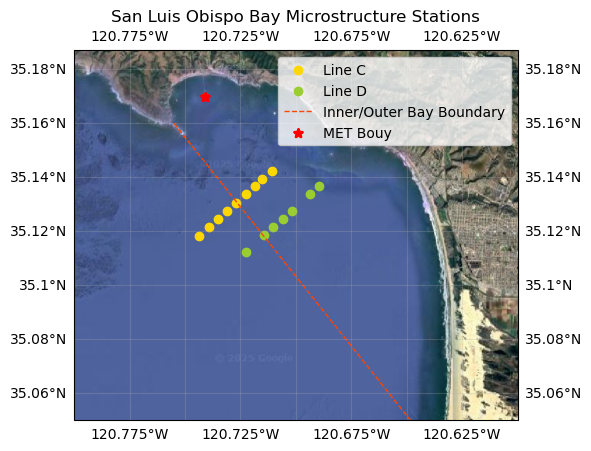

In [104]:
myfuncs.slo_map()

## Source of Turbulent Kinetic Dissipation Rates
Turbulent dissipation rate data is sourced from shipboard measurements of a high resolution MicroCTD. This instrument is equipped with two velocity shear probes oriented in the x and y-axis directions, an FP07 temperature probe, a JAC CT sensor, and a pressure transducer. Additionally a drag net was to moderate fall speed in case of variable water density. Microstructure profiles will be free-falling and taken along 2 designated transects serving as sampling paths for the MicroCTD. Along these transects are 9 predetermined stations at which at least two MicroCTD profiles will be taken at each station.
    
Microstructure data from the shear probes consists of a time series of velocity gradients  collected at 560 Hz. To estimate the rate of turbulent dissipation, a Fast Fourier Transform (FFT) converts the time series signal into frequencies by decomposing it into the sum of sines and cosines. For each FFT segment, the power spectral density function (PSD) computes the variance of the frequencies to determine the inertial subrange (the range where turbulent kinetic energy is transferred to smaller scales). Finally the frequency spectra are converted to wavenumber spectra and fitted to the Nasmyth Spectrum yielding the turbulent dissipation rate.

Below is a short summary of the specific steps used to convert shear probe measurements into usable turbulent dissipation rates. The data was  processed  with the help of the ODAS Matlab library and in accordance with the best practices outlined in Lueck et al. (2024). These practices include noise correction, spectral fitting, and proper averaging techniques to ensure reliable estimates in varying stratification and turbulence regimes.:
    
**Section Selection**: After the collection of MicroCTD data is completed, only the upcast of the profile is selected for analysis. To ensure reliable turbulence estimates, and avoid things like surface contamination,  the selected upcast is filtered so that only section values above the threshold for minimum pressure, minimum velocity and section duration are used.  

**Spectral Estimation**: The filtered profile time series is then divided into short overlapping FFT lengths of 1 second based on the high velocity of the microprofiler rather than the ODAS default of 2 to improve spatial resolution. An overlap of 50% for the FFT lengths was decided on the suggestion in Lueke et. al (2024). A cosine tapering window is then applied to the FFT lengths to reduce spectral leaking and ensure a smoother spectrum. Finally, the power spectral density of the velocity shear is then computed from each segment.

**Dissipation Rate Estimation**: Dissipation rate is estimated by fitting the observed shear spectrum to the Nasmyth Spectrum, which describes the shape of the theoretical turbulent shear spectrum in fully developed, isotropic turbulence. Fitting to  the spectrum, rather than integrating the observed spectrum directly was done since integration isn’t reliable unless the entire inertial subrange is resolved.
Quality Control and Uncertainty: The ODAS “get_diss” function was modified to also compute the fraction of variance resolved by the Nasmyth fit and the logarithmic uncertainty in ε, following Equation 17 of Lueck et al. (2024). Profile points are also excluded if the figure of merit shows that the observed spectrum is more than 1.4, indicating a poor match between observed values and Nasmyth (comparable to a low R-squared value in regression), or there is  high disagreement between probes.

## ANOVA Analysis

To understand how the rate of turbulent kinetic energy dissipation changes under different conditions in the bay, I used a one-way ANOVA to compare data grouped by wind strength, time of day, and distance across the bay. Although these variables are continuous data, and ideally should be analysed that way, detecting trends can be difficult when the data is all grouped together. Creating basic subdivisions in the data serves its purpose as a rudimentary first glance at detecting patterns in the data. While this method isn’t as statistically rigorous as a full continuous model (bias is introduced when defining thresholds, and smaller trends could be ignored), a one-way ANOVA allows for quick insight on whether these groups would reveal whether basic divisions in the data result in significantly different mean dissipation rates.

To determine how $\epsilon$ changes under different wind forcing conditions I start by separating my data into four categories: strong vs. weak winds and outside vs. inside the bay. Any wind greater than the halfway point between minimum and maximum wind value is identified as strong and any longitude value greater than  -120.725 is considered to be inside the bay. Additionally, To maintain consistency across samples of different depths and ensure that turbulence from bottom friction is excluded, only measurements taken at depths shallower than 10 meters were included in the analysis.

Similarly, to explore temporal variations in turbulence,  I separated my data into four categories: morning vs afternoon and outside vs. inside the bay. The cutoff between morning and afternoon is 1200 PST and was chosen based on the temporal variations in local diurnal wind patterns in SLO Bay from Walter et al. (2017).
Despite the advantages of ANOVA, one of its limitations is that it assumes normally distributed data and homogeneity of variance across groups. Turbulent dissipation data, however, is often non-normal and right-skewed. Although this violates ANOVA assumptions, one-way ANOVA is known to be relatively robust to moderate deviations from normality. Moreover, the interpretation of a large F-statistic would still indicate meaningful group differences even under slight assumption violations.

In [107]:
wind_threshold = 6 #m/s
bay_threshold = -120.725 #decimal degrees
max_pressure = 10 #dbar

df_strong_in, df_strong_out, df_weak_in, df_weak_out = myfuncs.strength_location_divisions(dsall, wind_threshold, bay_threshold, max_pressure)

df_in, df_out = myfuncs.location_divisions(df_strong_in, df_strong_out, df_weak_in, df_weak_out)
df_in_morning, df_out_morning, df_in_afternoon, df_out_afternoon = myfuncs.time_divisions(df_strong_in,df_strong_out, df_weak_in, df_weak_out)

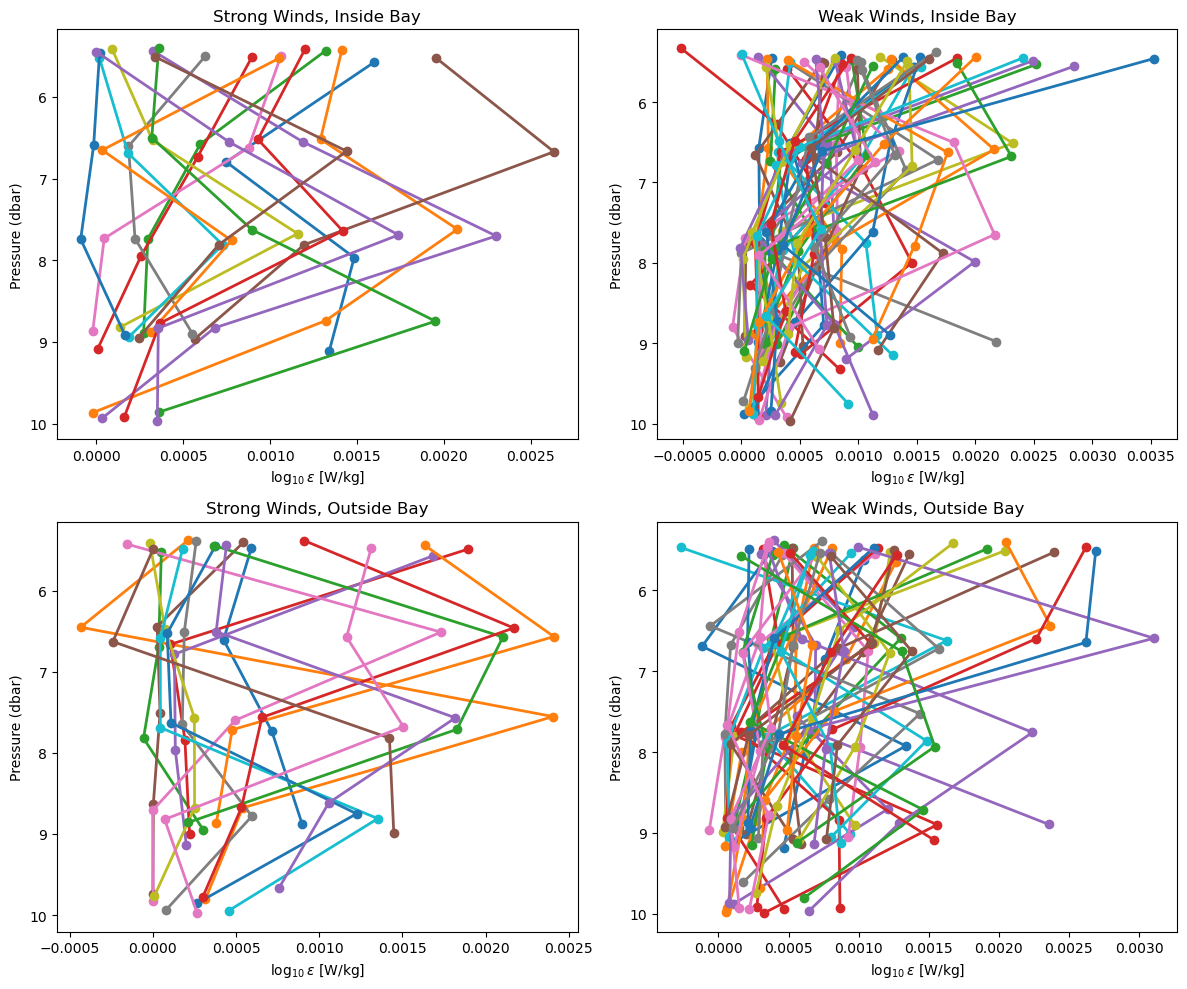

In [108]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

myfuncs.strength_location_division_plots(df_strong_in, title='Strong Winds, Inside Bay', ax=axs[0, 0])
myfuncs.strength_location_division_plots(df_weak_in, title='Weak Winds, Inside Bay', ax=axs[0, 1])
myfuncs.strength_location_division_plots(df_strong_out, title='Strong Winds, Outside Bay', ax=axs[1, 0])
myfuncs.strength_location_division_plots(df_weak_out, title='Weak Winds, Outside Bay', ax=axs[1, 1])

plt.tight_layout()

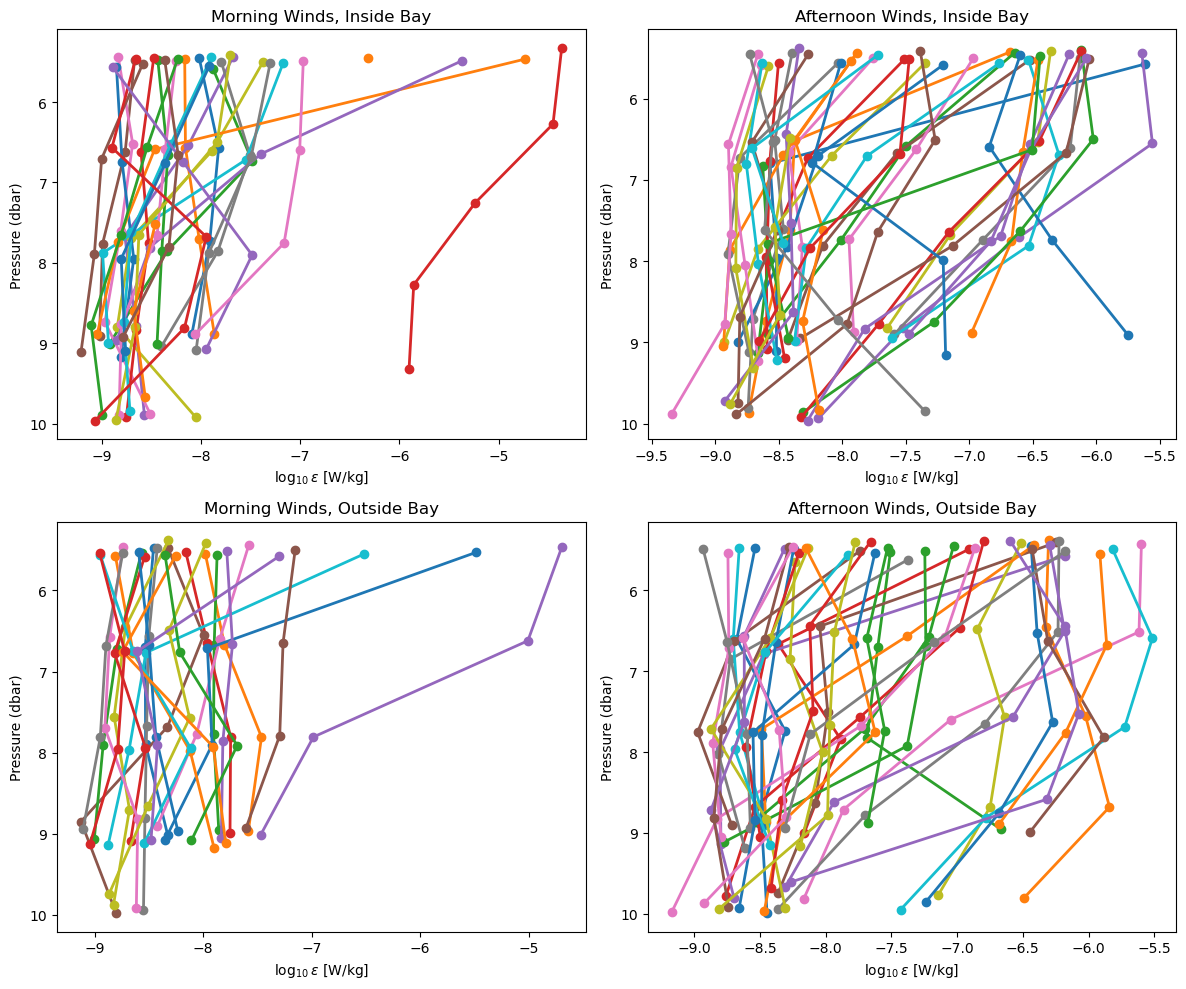

In [111]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

myfuncs.time_divisions_plot(df_in_morning, title='Morning Winds, Inside Bay', ax=axs[0, 0])
myfuncs.time_divisions_plot(df_in_afternoon, title='Afternoon Winds, Inside Bay', ax=axs[0, 1])
myfuncs.time_divisions_plot(df_out_morning, title='Morning Winds, Outside Bay', ax=axs[1, 0])
myfuncs.time_divisions_plot(df_out_afternoon, title='Afternoon Winds, Outside Bay', ax=axs[1, 1])

plt.tight_layout()

## Creation of wind time series

Constructing a time series of wind speed is essential for understanding the temporal variability and spatial differences in wind forcing across San Luis Obispo Bay. To achieve this, I compiled wind speed data from two primary sources: fixed-position buoys located inside and outside the bay, and shipboard wind measurements collected during the survey period. The fixed buoys provide continuous wind observations at specific locations, offering a reliable long-term view of regional and local wind dynamics.


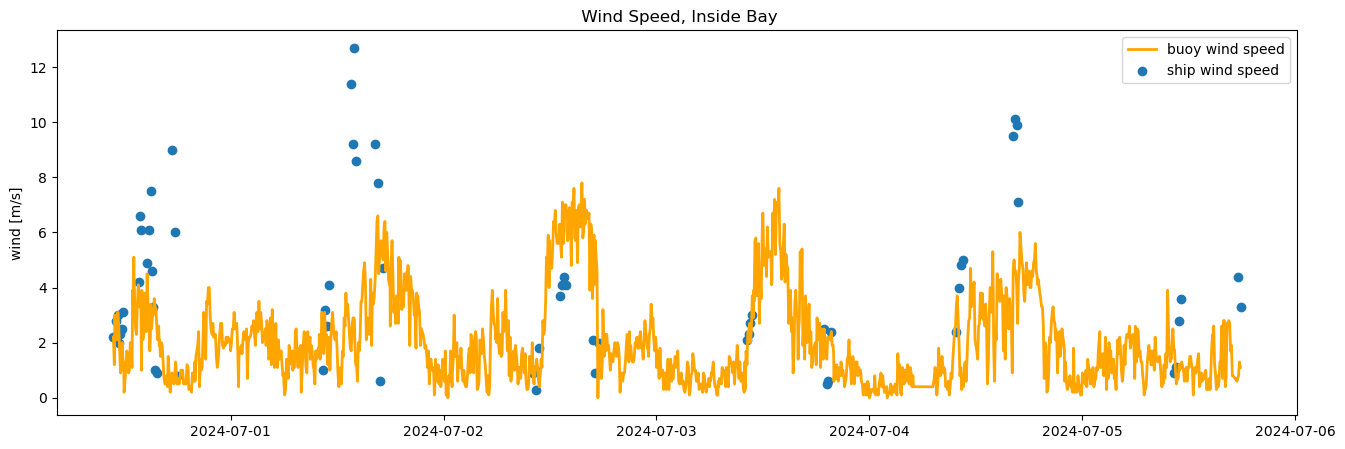

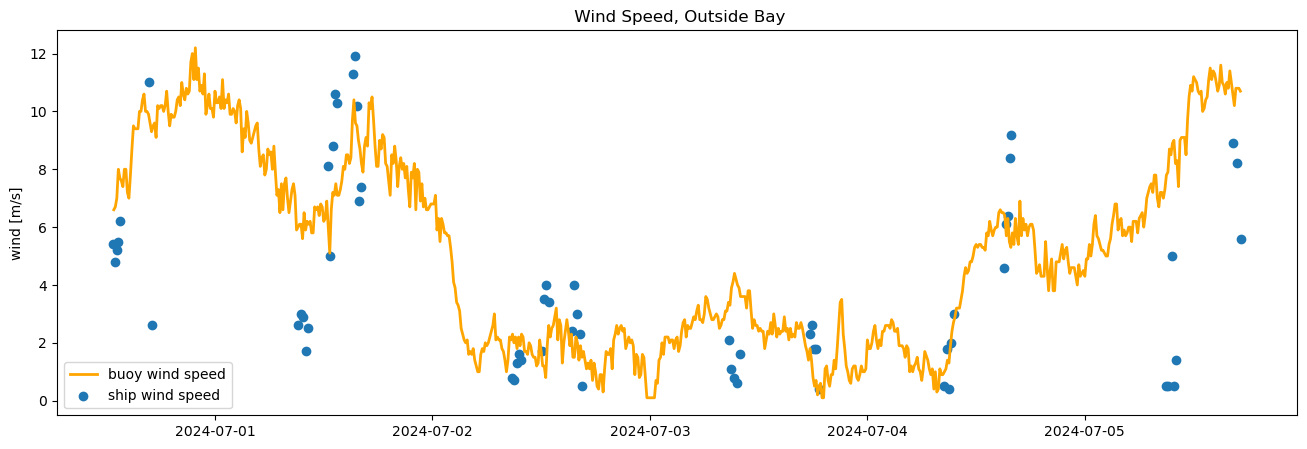

In [114]:
plt.figure(figsize=(16, 5))
myfuncs.ship_vs_buoy_timeseries(df_in, df_in_buoy, title=' Wind Speed, Inside Bay')
plt.figure(figsize=(16, 5))
myfuncs.ship_vs_buoy_timeseries(df_out, df_out_buoy, title=' Wind Speed, Outside Bay')

## Correlations
 

In addition to the grouped comparisons, I conducted linear regression analyses to explore potential correlations between key physical variables. Specifically, I investigated how wind speed relates to the rate of turbulent dissipation both inside and outside the bay.

Beyond wind speed, I also examined correlations between the buoyancy frequency and $\epsilon$ , to evaluate how stratification influences turbulence. Additional relationships explored include $\epsilon$  versus longitude, which can reveal spatial trends in dissipation across the bay, and the turbulence intensity parameter (I), which represents the balance between dissipation and stratification. 

Finally, I generated plots of $\epsilon$  and I as a function of longitude to visually identify spatial patterns and regions where dissipation and mixing intensities peak. This approach allows for easier visualization of where energetic mixing is occurring and how it may be modulated by spatial gradients in wind forcing or bathymetric features across San Luis Obispo Bay.


<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_6322/285314157.py:13: SyntaxWarning: invalid escape sequence '\e'
  cbar.set_label('Log$_{10}(\epsilon)$ [W/kg]')


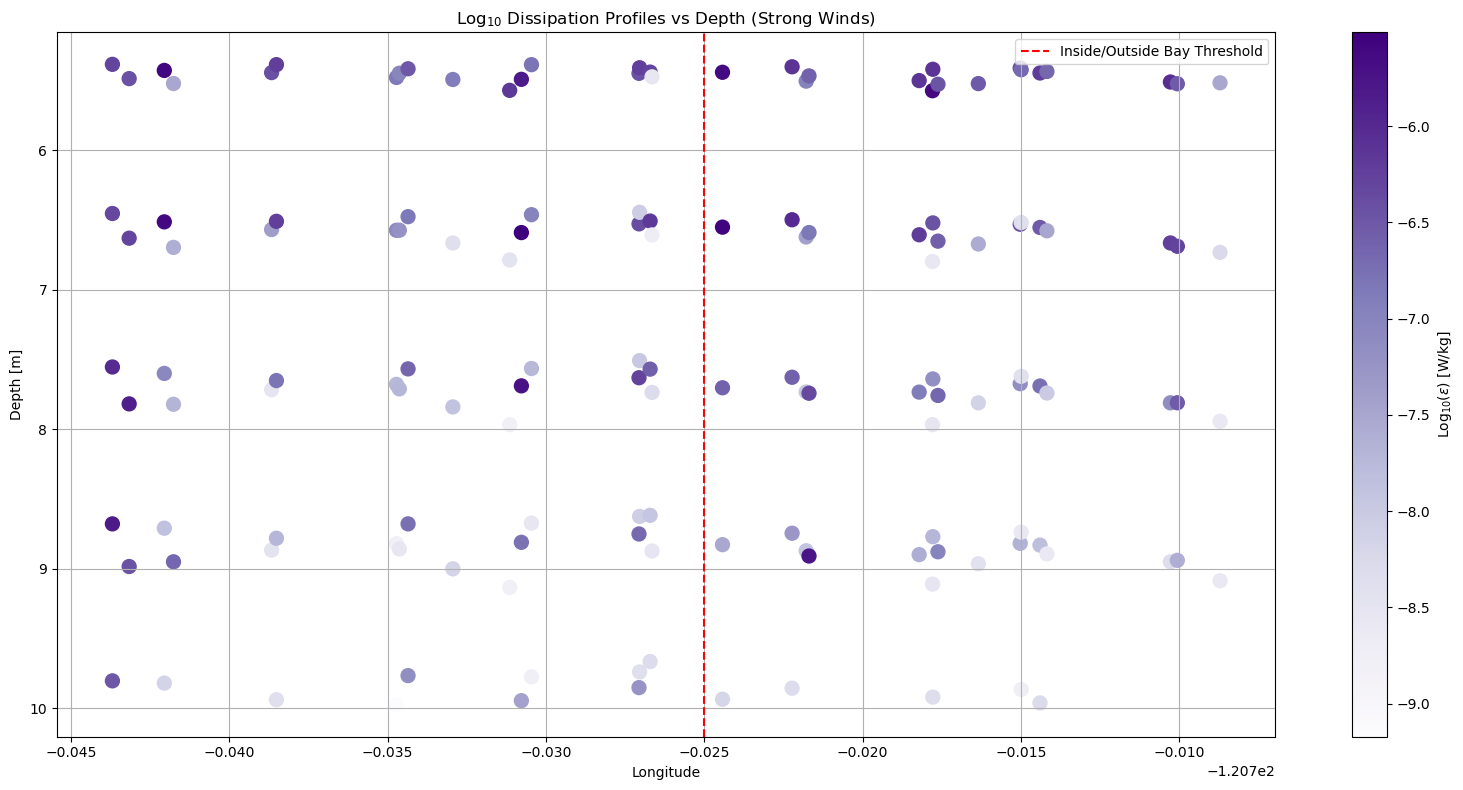

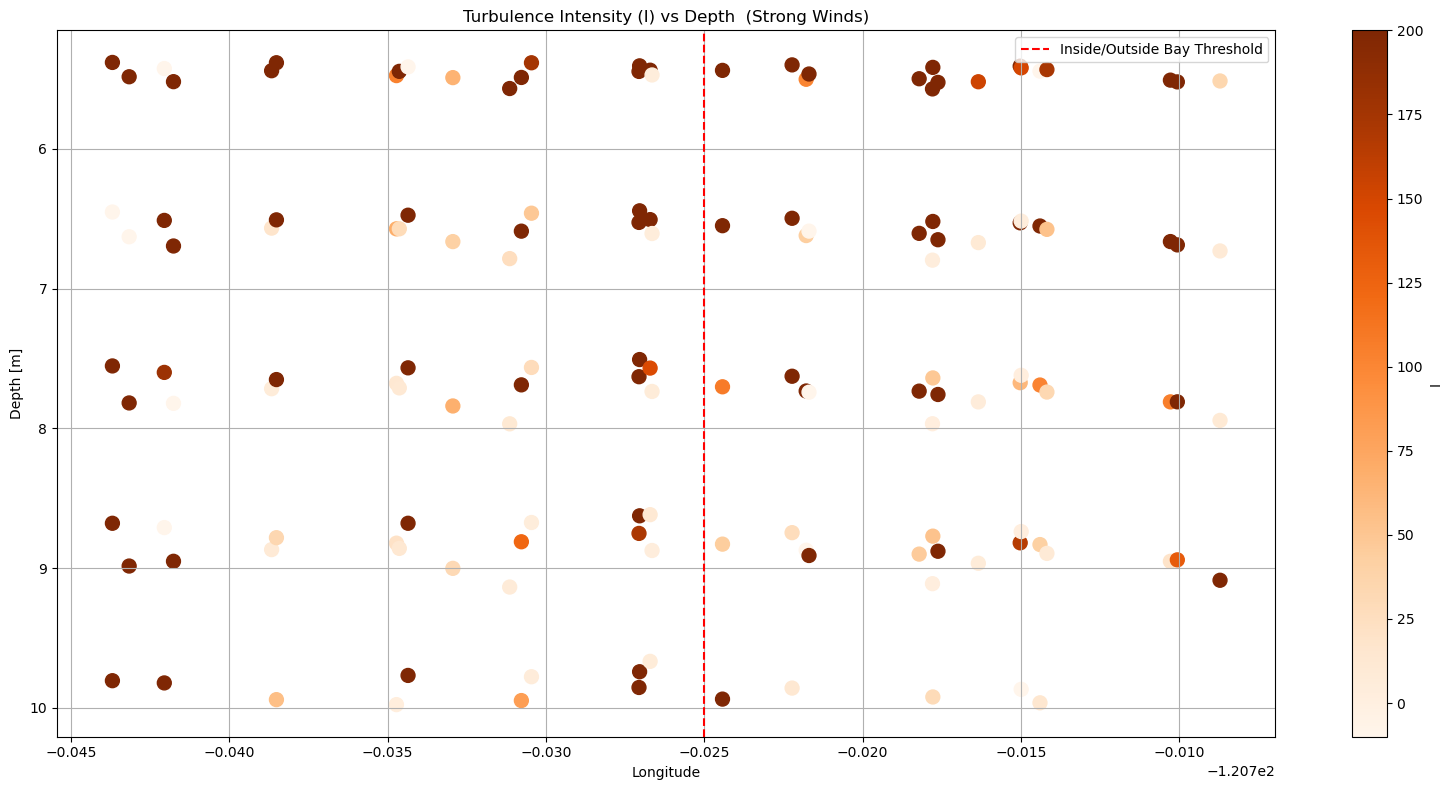

In [117]:
df_strong = pd.concat([df_strong_in, df_strong_out])
(longitudes, depths, log_dissipation, N_squareds, dissipation) = myfuncs.mask_flatten(df_strong)

plt.figure(figsize=(16, 8))
sc = plt.scatter(longitudes, depths, c=log_dissipation, cmap='Purples', s=100)
plt.gca().invert_yaxis()  # Depth increases downward
plt.axvline(-120.725, color='r', linestyle='--', label='Inside/Outside Bay Threshold')
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.legend()
plt.title('Log$_{10}$ Dissipation Profiles vs Depth (Strong Winds)')
cbar = plt.colorbar(sc)
cbar.set_label('Log$_{10}(\epsilon)$ [W/kg]')
plt.grid(True)
plt.tight_layout()

(I, longitudes, depths, N_squareds, dissipation) = myfuncs.turbulence_intensity_parameter(df_strong)

plt.figure(figsize=(16, 8))
sc = plt.scatter(longitudes, depths, c= I, cmap='Oranges', s=100, vmin=-10, vmax=200 )
plt.gca().invert_yaxis()  
plt.axvline(-120.725, color='r', linestyle='--', label='Inside/Outside Bay Threshold')
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.legend()
plt.title('Turbulence Intensity (I) vs Depth  (Strong Winds)')
cbar = plt.colorbar(sc)
cbar.set_label('I')
plt.grid(True)
plt.tight_layout()

<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
/var/folders/z6/mfhqh40j7zx7mbw6n6yshl5m0000gn/T/ipykernel_6322/165356655.py:13: SyntaxWarning: invalid escape sequence '\e'
  cbar.set_label('Log$_{10}(\epsilon)$ [W/kg]')


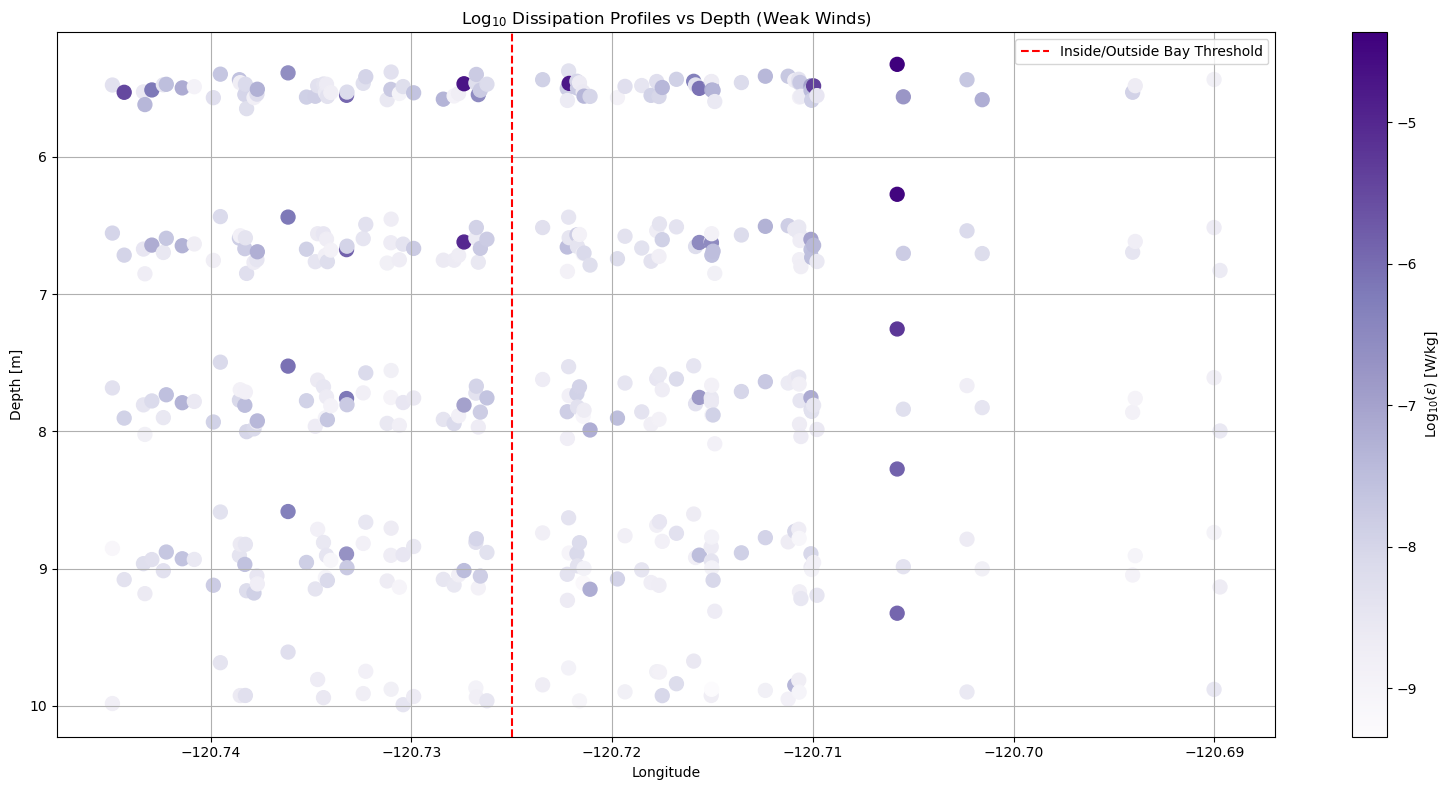

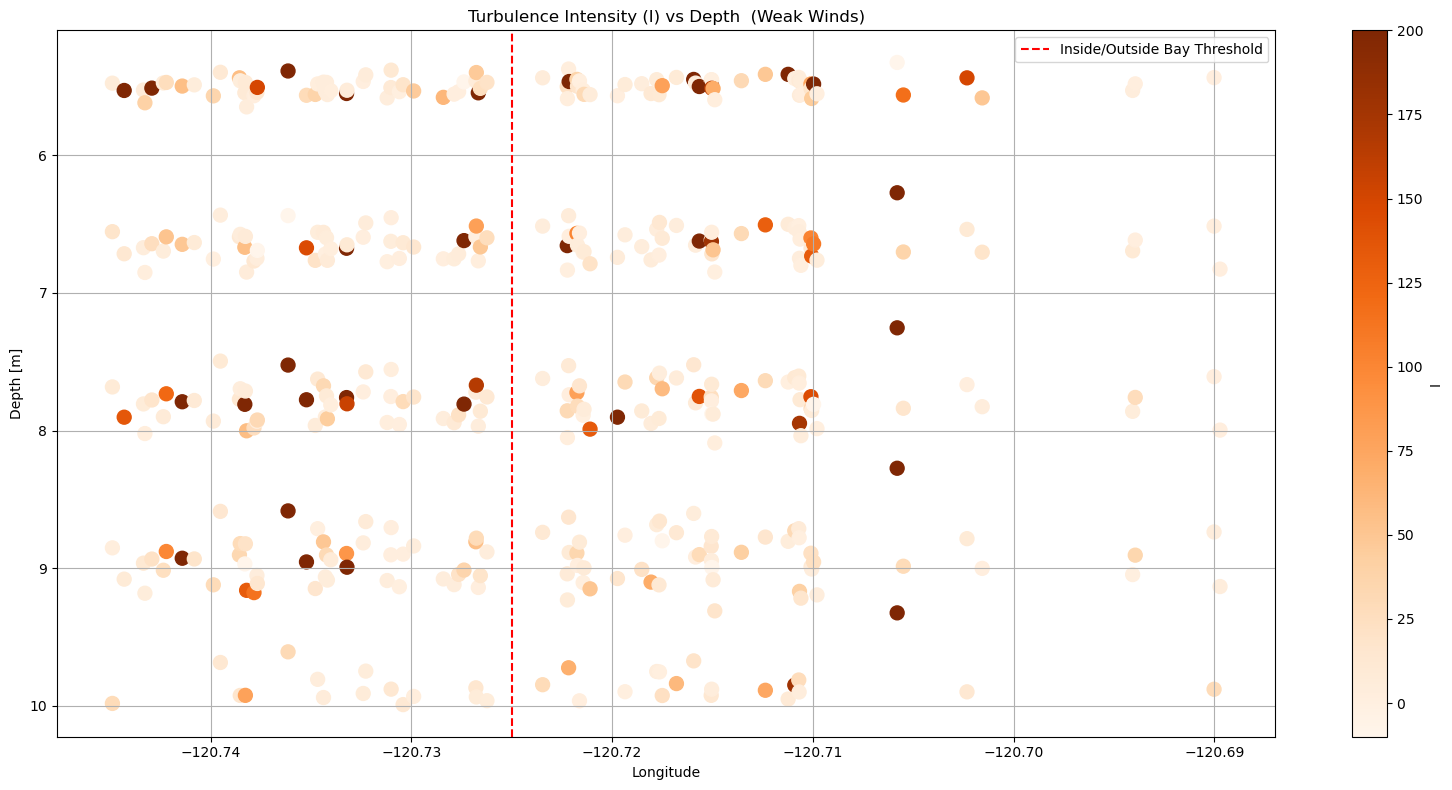

In [119]:
df_weak = pd.concat([df_weak_in, df_weak_out])
(longitudes, depths, log_dissipation, N_squareds, dissipation) = myfuncs.mask_flatten(df_weak)

plt.figure(figsize=(16, 8))
sc = plt.scatter(longitudes, depths, c=log_dissipation, cmap='Purples', s=100)
plt.gca().invert_yaxis()  # Depth increases downward
plt.axvline(-120.725, color='r', linestyle='--', label='Inside/Outside Bay Threshold')
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.legend()
plt.title('Log$_{10}$ Dissipation Profiles vs Depth (Weak Winds)')
cbar = plt.colorbar(sc)
cbar.set_label('Log$_{10}(\epsilon)$ [W/kg]')
plt.grid(True)
plt.tight_layout()

(I, longitudes, depths, N_squareds, dissipation) = myfuncs.turbulence_intensity_parameter(df_weak)

plt.figure(figsize=(16, 8))
sc = plt.scatter(longitudes, depths, c= I, cmap='Oranges', s=100, vmin=-10, vmax=200 )
plt.gca().invert_yaxis()  
plt.axvline(-120.725, color='r', linestyle='--', label='Inside/Outside Bay Threshold')
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.legend()
plt.title('Turbulence Intensity (I) vs Depth  (Weak Winds)')
cbar = plt.colorbar(sc)
cbar.set_label('I')
plt.grid(True)
plt.tight_layout()

# Results
## Wind Strength ANOVA

The one-way ANOVA comparing turbulent dissipation across different wind strength and bay location categories revealed a significant F-statistic of 18.47 and a p-value of 5.25 × 10e-10. A post hoc Tukey test was then performed to identify which specific groups differed. The results showed significant differences between nearly all groups, except between the strong wind inside the bay and strong wind outside the bay groups, and between the weak wind inside the bay and weak wind outside the bay groups. 

## Time of Day ANOVA
For the time-of-day comparison (morning vs. afternoon, inside vs. outside the bay), the one-way ANOVA also yielded a statistically significant result, with an F-statistic of 2.78 and a p-value of 0.0435. However, the post hoc Tukey test did not reveal any significant pairwise differences between the groups. This indicates that while there may be overall variance between group means, the differences between individual group combinations are not strong enough to be statistically distinguished in this dataset.


In [123]:
mean_strength_location = {'strong_in': df_strong_in,'strong_out': df_strong_out,'weak_in': df_weak_in,'weak_out': df_weak_out}
mean_strength_location = myfuncs.dissipation_profile_means(mean_strength_location)
strong_in = mean_strength_location['strong_in']
strong_out = mean_strength_location['strong_out']
weak_in = mean_strength_location['weak_in']
weak_out = mean_strength_location['weak_out']

mean_time_location = {'in_morning': df_in_morning,'out_morning': df_out_morning,'in_afternoon': df_in_afternoon,'out_afternoon': df_out_afternoon}
mean_time_location = myfuncs.dissipation_profile_means(mean_time_location)
morning_in = mean_time_location['in_morning']
morning_out = mean_time_location['out_morning']
afternoon_in = mean_time_location['in_afternoon']
afternoon_out = mean_time_location['out_afternoon']

In [125]:
F_scipy, pval = f_oneway(weak_in, weak_out, strong_in,strong_out)
print("F-statistic for wind strength commparison:", F_scipy)
print("p-value for wind strength comparison:", pval)
print(stats.tukey_hsd(weak_in, weak_out, strong_in,strong_out))

F_scipy, pval = f_oneway(morning_in, morning_out, afternoon_in,afternoon_out)
print("F-statistic for time comparison:", F_scipy)
print("p-value for time comparison:", pval)
print(stats.tukey_hsd(morning_in, morning_out, afternoon_in,afternoon_out))


F-statistic for wind strength commparison: 18.46934185981127
p-value for wind strength comparison: 5.253225789929509e-10
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.055     0.973    -0.387     0.278
 (0 - 2)     -1.004     0.000    -1.475    -0.533
 (0 - 3)     -0.939     0.000    -1.400    -0.479
 (1 - 0)      0.055     0.973    -0.278     0.387
 (1 - 2)     -0.949     0.000    -1.425    -0.473
 (1 - 3)     -0.884     0.000    -1.350    -0.419
 (2 - 0)      1.004     0.000     0.533     1.475
 (2 - 1)      0.949     0.000     0.473     1.425
 (2 - 3)      0.065     0.991    -0.508     0.638
 (3 - 0)      0.939     0.000     0.479     1.400
 (3 - 1)      0.884     0.000     0.419     1.350
 (3 - 2)     -0.065     0.991    -0.638     0.508

F-statistic for time comparison: 2.7848556418589974
p-value for time comparison: 0.04354008685506092
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence In

## Correlation Results
To examine the relationships between wind speed, turbulent dissipation, and stratification, several correlation analyses were performed, first using raw variables and then using log-transformed values for dissipation, buoyancy frequency, and the turbulence intensity parameter.

### Wind Speed and Dissipation
Using NumPy's Pearson correlation coefficient:
Outside wind speed vs. dissipation: r = 0.534
Inside wind speed vs. dissipation: r = 0.515
These results indicate a moderate positive correlation between wind speed and turbulent dissipation in both regions, suggesting that stronger winds are generally associated with greater mixing energy.

### Correlation Checks
No meaningful correlation was found between dissipation and the following parameters when using non-transformed values for dissipation, buoyancy frequency, or the turbulence intensity parameter (I). This could imply that these relationships are nonlinear so log-transformed variables were analyzed separately for strong and weak wind conditions:

**Weak Wind Conditions**
* log(dissipation) vs. log(N^2) showed a weak but significant positive correlation with  r = 0.189, p = 0.0001
* I vs. log(N^2) showed a strong negative correlation with r = –0.759, p ≈ 1.46 × 10e-78
* I vs. log(dissipation) showed a moderate positive correlation with r = 0.460, p ≈ 4.97 × 10e-24

**Strong Wind Conditions**
* log(dissipation) vs. log(N^2) was not statistically significant with r = 0.150, p = 0.082
* I vs. log(N^2) showed a strong negative correlation with r = –0.737, p ≈ 1.43 × 10 e-24
* I vs. log(dissipation) showed a moderate positive correlation with r = 0.524, p ≈ 6.03 × 10e-11

These results indicate that under both weak and strong wind conditions, the turbulence intensity parameter (I) is strongly and significantly related to both dissipation and stratification, negatively with buoyancy frequency, and positively with the rate of turbulent dissipation. Furthermore, no relationship was found between any of these variables and  longitude.


In [128]:
# Ensure inputs are NumPy arrays

(longitudes, depths, log_dissipation, N_squareds, dissipation) = myfuncs.mask_flatten(df_strong)
(I, longitudes, depths, N_squareds, dissipation) = myfuncs.turbulence_intensity_parameter(df_strong)

viscosity = 10**(-6) #m^2/s
dissipation = np.array(dissipation)
N_squareds = np.array(N_squareds)
log_nu = np.log(viscosity)

# Mask to avoid zeros
valid = (dissipation > 0) & (N_squareds > 0)

I = np.full_like(dissipation, np.nan)
I[valid] = np.log(dissipation[valid]) / (np.log(N_squareds[valid]) * log_nu)


#Correlation results from strong winds
slope, intercept, r_val, p_val, std_err = linregress(np.log(dissipation[valid]), np.log(N_squareds[valid]))
print('log(dissipation) vs. log(N^2),r_val, p_val: ', r_val, p_val)
slope, intercept, r_val, p_val, std_err = linregress(I[valid], np.log(N_squareds[valid]))
print('I vs. log(N^2), r_val, p_val: ', r_val, p_val)
slope, intercept, r_val, p_val, std_err = linregress(I[valid], np.log(dissipation[valid]))
print('log(dissipation) vs. I, r_val, p_val: ', r_val, p_val)

log(dissipation) vs. log(N^2),r_val, p_val:  0.14960710417275663 0.08214085606517975
I vs. log(N^2), r_val, p_val:  -0.7371746414825571 1.427524757854727e-24
log(dissipation) vs. I, r_val, p_val:  0.5237531361930967 6.031219934164828e-11


In [130]:
# Ensure inputs are NumPy arrays

(longitudes, depths, log_dissipation, N_squareds, dissipation) = myfuncs.mask_flatten(df_weak)
(I, longitudes, depths, N_squareds, dissipation) = myfuncs.turbulence_intensity_parameter(df_weak)

viscosity = 10**(-6) #m^2/s
dissipation = np.array(dissipation)
N_squareds = np.array(N_squareds)
log_nu = np.log(viscosity)

# Mask to avoid zeros
valid = (dissipation > 0) & (N_squareds > 0)

I = np.full_like(dissipation, np.nan)
I[valid] = np.log(dissipation[valid]) / (np.log(N_squareds[valid]) * log_nu)


#Correlation results from weak winds
slope, intercept, r_val, p_val, std_err = linregress(np.log(dissipation[valid]), np.log(N_squareds[valid]))
print('log(dissipation) vs. log(N^2),r_val, p_val: ', r_val, p_val)
slope, intercept, r_val, p_val, std_err = linregress(I[valid], np.log(N_squareds[valid]))
print('I vs. log(N^2), r_val, p_val: ', r_val, p_val)
slope, intercept, r_val, p_val, std_err = linregress(I[valid], np.log(dissipation[valid]))
print('log(dissipation) vs. I, r_val, p_val: ', r_val, p_val)

log(dissipation) vs. log(N^2),r_val, p_val:  0.18944590325446103 0.00010730130587033792
I vs. log(N^2), r_val, p_val:  -0.7588610119303579 1.4616963847103046e-78
log(dissipation) vs. I, r_val, p_val:  0.4601254700706523 4.9705818563520614e-23


# Discussion and Conclusions

Together, the ANOVA and correlation results support the idea that wind speed is a dominant driver of turbulent energy dissipation, but also show that the relationship between dissipation, stratification is nonlinear.

## Wind Strength as a Primary Driver

The ANOVA comparing dissipation across strong and weak wind regimes, inside and outside the bay, revealed highly significant differences in dissipation rates across categories. This supports the hypothesis that wind strength is a key control on turbulent energy in the system. However the spatial location (inside vs. outside the bay) does not consistently lead to statistically distinct dissipation rates under similar wind regimes. It would be interesting to see if these results change if time is introduced as a second variable in this wind strength analysis, as winds inside the bay might be weak when winds outside the bay are strong.

## Time-of-Day Patterns

The time-of-day ANOVA showed overall significant differences in dissipation, but the lack of significant post hoc pairwise differences suggests that any temporal modulation of turbulence is either subtle or dominated by other variability. While wind intensifies in the afternoon due to the sea breeze, its effect on turbulence may not create discrete morning–afternoon regimes but may have a more gradual effect that is also impacted by regional upwelling wind stress.

## Correlations Between Wind, Dissipation, and Stratification

Linear correlations between wind speed and dissipation showed moderate positive relationships both inside and outside the bay. This aligns with the fact higher winds inject more kinetic energy into the surface boundary layer, leading to enhanced turbulence and mixing.
Interestingly, initial linear analyses did not reveal significant correlations between dissipation and either buoyancy frequency or the turbulence intensity parameter (I). However, log-transformed analyses revealed important scale-dependent relationships. As expected, under both strong and weak wind conditions, the turbulence intensity parameter showed a strong negative correlation with log(N^2) and a moderate positive correlation with log($\epsilon$ ). The consistent negative relationship between I and N² enforces that strong stratification tends to suppress turbulence, while the positive relationship between I and dissipation reinforces its usefulness in diagnosing turbulent regimes.

Correlations between dissipation and N² were weak or insignificant, especially under strong wind conditions. This may reflect the fact that under strong winds, turbulence is driven primarily by surface forcing and becomes decoupled from stratification in the upper water column. 

## Spatial Structure and Longitude

Across all analyses, longitude did not appear to play a significant role in controlling turbulence. This suggests that any cross-bay gradients in dissipation are either small relative to temporal variability or not well-captured by a single longitudinal cutoff. While the division at –120.725 effectively separated “inside” and “outside” locations for categorical analysis, the continuous spatial structure of turbulence may be more complex, requiring more spatially resolved measurements or a more nuanced metric of distance from shore or frontal zones.

## Limitations and Future Directions

While the use of ANOVA and correlation analysis provided insight into general trends, several assumptions and limitations must be acknowledged. The grouping thresholds (e.g., mean wind speed, –120.725° longitude, 1200 PST cutoff) , while reasonable, may oversimplify spatial and temporal dynamics. Additionally, ANOVA assumes normality and equal variance, which does not hold for the data.

Finally, Future work could expand on these findings by incorporating more physically grounded thresholds, and using continuous methods for analysis in order to see finer resolution, but significant trends. More detailed investigation of frontal dynamics, wind curl, and shear instabilities may also help clarify the mechanisms behind observed turbulence patterns.


## References

Barth, A., R. Walter, I. Robbins, and A. Pasulka (2020), Seasonal and interannual variability of phytoplankton abundance and community composition on the Central Coast of California, Marine Ecology Progress Series, 637, 29–43, doi:10.3354/meps13245. 

Batchelor, G. K. (1999), The theory of homogeneous turbulence, Cambridge University Press, Cambridge. 
Craig, P. D. (1996), Velocity profiles and surface roughness under breaking waves, Journal of Geophysical Research: Oceans, 101(C1), 1265–1277, doi:10.1029/95jc03220. 

Largier, J. L. (2020), Upwelling Bays: How Coastal Upwelling controls circulation, habitat, and productivity in bays, Annual Review of Marine Science, 12(1), 415–447, doi:10.1146/annurev-marine-010419-011020. 

Lueck, R., I. Fer, C. Bluteau, M. Dengler, P. Holtermann, R. Inoue, A. LeBoyer, S.-A. Nicholson, K. Schulz, and C. Stevens (2024), Best practices recommendations for estimating dissipation rates from shear probes, Frontiers in Marine Science, 11, doi:10.3389/fmars.2024.1334327. 

Smits, A. J., B. J. McKeon, and I. Marusic (2011), High–Reynolds Number Wall Turbulence, Annual Review of Fluid Mechanics, 43(1), 353–375, doi:10.1146/annurev-fluid-122109-160753. 

Thorpe, S. A. (2007), An Introduction to Ocean Turbulence, Cambridge University Press, Cambridge. 

Walter, R. K., E. C. Reid, K. A. Davis, K. J. Armenta, K. Merhoff, and N. J. Nidzieko (2017), Local diurnal wind‐driven variability and upwelling in a small coastal embayment, Journal of Geophysical Research: Oceans, 122(2), 955–972, doi:10.1002/2016jc012466. 
